In [202]:
import numpy as np
import pandas as pd
import math
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.neural_network import MLPClassifier
import tqdm
from scipy.interpolate import griddata
import heapq
from mpl_toolkits.mplot3d import Axes3D

In [325]:
# Function to initialize ratings
def initialize_ratings(df_results, df_fixtures, df_int_results, df_int_fixtures):
    ratings = {}
    league_ratings = {}

    # Get the list of competitions
    competitions = set(df_results['Div']).union(set(df_fixtures['Div'])).union(set(df_int_results['HomeDiv'])).union(set(df_int_fixtures['HomeDiv'])).union(set(df_int_results['AwayDiv'])).union(set(df_int_fixtures['AwayDiv']))

    # Iterate over teams in the results data
    teams = set(df_results['HomeTeam']).union(set(df_results['AwayTeam'])).union(set(df_fixtures['HomeTeam'])).union(set(df_fixtures['AwayTeam'])).union(set(df_int_results['HomeTeam'])).union(set(df_int_fixtures['HomeTeam'])).union(set(df_int_results['AwayTeam'])).union(set(df_int_fixtures['AwayTeam']))

    for team in teams:
        ratings[team] = {}

        # Initialize ratings for each team for each competition
        for competition in competitions:
            ratings[team][competition] = {
                'brH': 0.0,
                'brA': 0.0,
                'continuous_overunderperformances': 0
            }
            
    """
    # Initialize ratings for each competition
    league_ratings['REST'] = {
        'brH': 0.0,
        'brA': 0.0,
        'continuous_overunderperformances': 0
    }
    """
    
    for competition in competitions:
        league_ratings[competition] = {
            'INT1': {
                'brH': 0.0,
                'brA': 0.0,
                'continuous_overunderperformances': 0,
            },
            'DCUP': {
                'brH': 0.0,
                'brA': 0.0,
                'continuous_overunderperformances': 0,
            }
        }

    #print('Teams:', teams, end='\n\n')
    return ratings, league_ratings


In [326]:
def initialize_rest_ratings(rest_teams):
    rest_ratings = {}
    for team in rest_teams:
        rest_ratings[team] = {
            'REST': {
                'brH': 0.0,
                'brA': 0.0,
                'continuous_overunderperformances': 0
            }
        }
    return rest_ratings

In [327]:
def create_team_to_league_mapping(df_results, df_fixtures, df_int):
    team_to_league = {}
    rest_teams = set() # To store teams that are assigned to the 'REST' league

    def get_league_level(division):
        # Extracting the integer part from the division
        integer_part = ''.join(filter(str.isdigit, division))
        return int(integer_part)


    # Iterate through the results and fixtures dataframes and map teams to their leagues
    for df in [df_results, df_fixtures]:
        for index, row in df.iterrows():
            for team in [row['HomeTeam'], row['AwayTeam']]:
                current_div = row['Div']
                current_level = get_league_level(current_div)

                # If the team is not yet in the dictionary, or if the current league is higher, update the entry
                if team not in team_to_league or current_level < get_league_level(team_to_league[team]):
                    team_to_league[team] = current_div

    # Now process df_int
    for index, row in df_int.iterrows():
        for team in [row['HomeTeam'], row['AwayTeam']]:
            if team not in team_to_league:
                # If the team is not found in the other dataframes, assign it to 'REST'
                team_to_league[team] = 'REST'
                rest_teams.add(team)

    return team_to_league, rest_teams

In [328]:
def get_league_from_team(team, team_to_league):
    return team_to_league.get(team, 'REST')

In [329]:
# Function to update ratings based on results data
def update_ratings_multiple_games(df_results, ratings, league_ratings, rates):
    ind_threshold = rates['ind_threshold']
    games_with_rating = []
    training_games = []

    # Iterate over each match in the results data
    for index, row in df_results.iterrows():

        # Identify the competition in which the match took place
        competition = row['Div']

        if index > ind_threshold:
            #add current game to training data
            training_games.append({
                #"brH_x": ratings[row["HomeTeam"]][competition]["brH"],
                #"brA_x": ratings[row["HomeTeam"]][competition]["brA"],
                #"prH_x": calculate_provisional_ratings(ratings, row["HomeTeam"], competition, rates)[0],
                #"prA_x": calculate_provisional_ratings(ratings, row["HomeTeam"], competition, rates)[1],
                #"brH_y": ratings[row["AwayTeam"]][competition]["brH"],
                #"brA_y": ratings[row["AwayTeam"]][competition]["brA"],
                #"prH_y": calculate_provisional_ratings(ratings, row["AwayTeam"], competition, rates)[0],
                #"prA_y": calculate_provisional_ratings(ratings, row["AwayTeam"], competition, rates)[1],
                "rating_difference": (calculate_provisional_ratings(ratings, row["HomeTeam"], competition, rates)[0]) - (calculate_provisional_ratings(ratings, row["AwayTeam"], competition, rates)[1]),
                #"FTHG": row["FTHG"],
                #"FTAG": row["FTAG"],
                "FTR": row["FTR"]
            })


        if np.isnan(ratings[row["HomeTeam"]][competition]["brH"]):
            print("error")
            break

        ratings = update_ratings_single_game(row['HomeTeam'], row['AwayTeam'], row['FTHG'], row['FTAG'], ratings, league_ratings, rates, competition)

        games_with_rating.append({
            "team": row["HomeTeam"],
            "home_rating": ratings[row["HomeTeam"]][competition]["brH"],
            "away_rating": ratings[row["HomeTeam"]][competition]["brA"],
            "continuous_overunderperformances": ratings[row["HomeTeam"]][competition]["continuous_overunderperformances"],
        })

        games_with_rating.append({
            "team": row["AwayTeam"],
            "home_rating": ratings[row["AwayTeam"]][competition]["brH"],
            "away_rating": ratings[row["AwayTeam"]][competition]["brA"],
            "continuous_overunderperformances": ratings[row["AwayTeam"]][competition]["continuous_overunderperformances"],
        })

    return ratings, games_with_rating, training_games

In [330]:
def update_league_ratings_multiple_games(df_int_results, league_ratings, rates):
    # Iterate over each match in the international results data
    for index, row in df_int_results.iterrows():
        # Extract relevant information from the row
        HomeLeague = row['HomeDiv']
        AwayLeague = row['AwayDiv']
        Div = row['Div']
        FTHG = row['FTHG']
        FTAG = row['FTAG']

        # Update the league ratings based on the match result
        league_ratings = update_league_ratings_single_game(HomeLeague, AwayLeague, Div, FTHG, FTAG, league_ratings, rates)

    return league_ratings


In [346]:
# Function to update ratings based on results data
def update_ratings_single_game(HomeTeam, AwayTeam, FTHG, FTAG, ratings, league_ratings, rates, competition):

    #lambda: Determines to what extent the new match results influence the team ratings (could be improved to include temporal difference between matches)
    #learning_rate_lambda = 0.054
    learning_rate_lambda = rates['lambda']

    #psi: diminish the impact each additional goal difference error has on team ratings
    diminishing_function_psi = lambda error: 3 * np.log10(1 + error)

    #gamma: determines to what extent performances at the home grounds influence away team ratings and vice versa
    #learning_rate_gamma = 0.79
    learning_rate_gamma = rates['gamma']
    
    tau = rates['tau']

    #print(HomeTeam, "-", AwayTeam, FTHG, ":", FTAG)

    observed_goal_difference = FTHG - FTAG
    #print("Observed Goal Difference:", observed_goal_difference)
    
    competitions = set(ratings[HomeTeam].keys()).union(set(ratings[AwayTeam].keys()))
    """
    if ratings[HomeTeam][competition]['brH'] == 0 and ratings[HomeTeam][competition]['brA'] == 0:
        for otherCompetition in competitions:
            if ratings[HomeTeam][otherCompetition]['brH'] != 0 or ratings[HomeTeam][otherCompetition]['brA'] != 0:
                ratings[HomeTeam][competition]['brH'] = ratings[HomeTeam][otherCompetition]['brH'] + tau * (league_ratings[otherCompetition]['DCUP']['brH'] - league_ratings[competition]['DCUP']['brH'])
                ratings[HomeTeam][competition]['brA'] = ratings[HomeTeam][otherCompetition]['brA'] + tau * (league_ratings[otherCompetition]['DCUP']['brA'] - league_ratings[competition]['DCUP']['brA'])
                print ("Team", HomeTeam, "new Competition", competition, "old Competition", otherCompetition, "new brH", ratings[HomeTeam][competition]['brH'], "new brA", ratings[HomeTeam][competition]['brA'])

    if ratings[AwayTeam][competition]['brA'] == 0 and ratings[AwayTeam][competition]['brH'] == 0:
        for otherCompetition in competitions:
            if ratings[AwayTeam][otherCompetition]['brA'] != 0 or ratings[AwayTeam][otherCompetition]['brH'] != 0:
                ratings[AwayTeam][competition]['brA'] = ratings[AwayTeam][otherCompetition]['brA'] + tau * (league_ratings[otherCompetition]['DCUP']['brA'] - league_ratings[competition]['DCUP']['brA']) 
                ratings[AwayTeam][competition]['brH'] = ratings[AwayTeam][otherCompetition]['brH'] + tau * (league_ratings[otherCompetition]['DCUP']['brH'] - league_ratings[competition]['DCUP']['brH']) 
                print ("Team", AwayTeam, "new Competition", competition, "old Competition", otherCompetition, "new brA", ratings[AwayTeam][competition]['brA'], "new brH", ratings[AwayTeam][competition]['brH'])
    """         
    #Calculate expected goals for home team
    #expected_goal_x = round((10 ** (abs(ratings[HomeTeam]['brH']) / 3)) - 1,5)
    expected_goal_x_temp = abs(ratings[HomeTeam][competition]['brH']) / 3
    expected_goal_x = np.sign(ratings[HomeTeam][competition]['brH']) * (np.power(10, expected_goal_x_temp) - 1)
    #print("Expected Goals x:", expected_goal_x)

    # Calculate expected goals for away team
    #expected_goal_y = round((10 ** (abs(ratings[AwayTeam]['brA']) / 3)) - 1,5)
    expected_goal_y_temp = abs(ratings[AwayTeam][competition]['brA']) / 3
    expected_goal_y = np.sign(ratings[AwayTeam][competition]['brA']) * (np.power(10, expected_goal_y_temp) - 1)
    #print("Expected Goals y:", expected_goal_y)

    # Calculate expected goal difference based on ratings
    expected_goal_difference = expected_goal_x - expected_goal_y
    #print("Expected Goal Difference:", expected_goal_difference)

    # Calculate the error between observed and expected goal difference
    error = abs(observed_goal_difference - expected_goal_difference)
    #print("error:", error)

    psi_temp = diminishing_function_psi(error)

    # Diminish the impact of the goal difference error for both teams x and y respectively
    if (expected_goal_difference < observed_goal_difference):
        diminishing_function_psi_x = psi_temp
        diminishing_function_psi_y = -psi_temp
    else:
        diminishing_function_psi_x = -psi_temp
        diminishing_function_psi_y = psi_temp
    #print("Diminishing Function psi x:", diminishing_function_psi_x)
    #print("Diminishing Function psi y:", diminishing_function_psi_y)

    # Update the home team x background ratings
    previous_home_rating_x = ratings[HomeTeam][competition]['brH']
    previous_away_rating_x = ratings[HomeTeam][competition]['brA']
    #print("Old brH x:", previous_home_rating_x)
    #print("Old brA x:", previous_away_rating_x)

    ratings[HomeTeam][competition]['brH'] = previous_home_rating_x + diminishing_function_psi_x * learning_rate_lambda
    ratings[HomeTeam][competition]['brA'] = previous_away_rating_x + (ratings[HomeTeam][competition]['brH'] - previous_home_rating_x) * learning_rate_gamma
    #print("New brH x:", ratings[HomeTeam]['brH'])
    #print("New brA x:", ratings[HomeTeam]['brA'])

    # Update the away team y background ratings
    previous_home_rating_y = ratings[AwayTeam][competition]['brH']
    previous_away_rating_y = ratings[AwayTeam][competition]['brA']
    #print("Old brH y:", previous_home_rating_y)
    #print("Old brA y:", previous_away_rating_y)

    ratings[AwayTeam][competition]['brA'] = previous_away_rating_y + diminishing_function_psi_y * learning_rate_lambda
    ratings[AwayTeam][competition]['brH'] = previous_home_rating_y + (ratings[AwayTeam][competition]['brA'] - previous_away_rating_y) * learning_rate_gamma
    #print("New brH y:", ratings[AwayTeam]['brH'])
    #print("New brA y:", ratings[AwayTeam]['brA'])

    #print("Old overunderperformance x:", ratings[HomeTeam]['continuous_overunderperformances'])
    #print("Old overunderperformance y:", ratings[AwayTeam]['continuous_overunderperformances'])

    # Update the continuous over/underperformances for the home team
    if (observed_goal_difference > expected_goal_difference):
        ratings[HomeTeam][competition]['continuous_overunderperformances'] = max(1, ratings[HomeTeam][competition]['continuous_overunderperformances'] + 1)
        ratings[AwayTeam][competition]['continuous_overunderperformances'] = min(-1, ratings[AwayTeam][competition]['continuous_overunderperformances'] - 1)
    elif (observed_goal_difference < expected_goal_difference):
        ratings[HomeTeam][competition]['continuous_overunderperformances'] = min(-1, ratings[HomeTeam][competition]['continuous_overunderperformances'] - 1)
        ratings[AwayTeam][competition]['continuous_overunderperformances'] = max(1, ratings[AwayTeam][competition]['continuous_overunderperformances'] + 1)
    else:
        ratings[HomeTeam][competition]['continuous_overunderperformances'] = 0
        ratings[AwayTeam][competition]['continuous_overunderperformances'] = 0

    #print("New overunderperformance x:", ratings[HomeTeam]['continuous_overunderperformances'])
    #print("New overunderperformance y:", ratings[AwayTeam]['continuous_overunderperformances'], end='\n\n')

    return ratings


In [347]:
# Function to update ratings based on results data
def update_league_ratings_single_game(HomeLeague, AwayLeague, Div, FTHG, FTAG, league_ratings, rates):

    #lambda: Determines to what extent the new match results influence the team ratings (could be improved to include temporal difference between matches)
    #learning_rate_lambda = 0.054
    learning_rate_lambda = rates['lambda2']

    #psi: diminish the impact each additional goal difference error has on team ratings
    diminishing_function_psi = lambda error: 3 * np.log10(1 + error)

    #gamma: determines to what extent performances at the home grounds influence away team ratings and vice versa
    #learning_rate_gamma = 0.79
    learning_rate_gamma = rates['gamma2']

    #print(HomeTeam, "-", AwayTeam, FTHG, ":", FTAG)


    observed_goal_difference = FTHG - FTAG
    #print("Observed Goal Difference:", observed_goal_difference)

    #Calculate expected goals for home team
    #expected_goal_x = round((10 ** (abs(ratings[HomeTeam]['brH']) / 3)) - 1,5)
    expected_goal_x_temp = abs(league_ratings[HomeLeague][Div]['brH']) / 3
    expected_goal_x = np.sign(league_ratings[HomeLeague][Div]['brH']) * (np.power(10, expected_goal_x_temp) - 1)
    #print("Expected Goals x:", expected_goal_x)

    # Calculate expected goals for away team
    #expected_goal_y = round((10 ** (abs(ratings[AwayTeam]['brA']) / 3)) - 1,5)
    expected_goal_y_temp = abs(league_ratings[AwayLeague][Div]['brA']) / 3
    expected_goal_y = np.sign(league_ratings[AwayLeague][Div]['brA']) * (np.power(10, expected_goal_y_temp) - 1)
    #print("Expected Goals y:", expected_goal_y)

    # Calculate expected goal difference based on ratings
    expected_goal_difference = expected_goal_x - expected_goal_y
    #print("Expected Goal Difference:", expected_goal_difference)

    # Calculate the error between observed and expected goal difference
    error = abs(observed_goal_difference - expected_goal_difference)
    #print("error:", error)

    psi_temp = diminishing_function_psi(error)

    # Diminish the impact of the goal difference error for both teams x and y respectively
    if (expected_goal_difference < observed_goal_difference):
        diminishing_function_psi_x = psi_temp
        diminishing_function_psi_y = -psi_temp
    else:
        diminishing_function_psi_x = -psi_temp
        diminishing_function_psi_y = psi_temp
    #print("Diminishing Function psi x:", diminishing_function_psi_x)
    #print("Diminishing Function psi y:", diminishing_function_psi_y)

    # Update the home team x background ratings
    previous_home_rating_x = league_ratings[HomeLeague][Div]['brH']
    previous_away_rating_x = league_ratings[HomeLeague][Div]['brA']
    #print("Old brH x:", previous_home_rating_x)
    #print("Old brA x:", previous_away_rating_x)

    league_ratings[HomeLeague][Div]['brH'] = previous_home_rating_x + diminishing_function_psi_x * learning_rate_lambda
    league_ratings[HomeLeague][Div]['brA'] = previous_away_rating_x + (league_ratings[HomeLeague][Div]['brH'] - previous_home_rating_x) * learning_rate_gamma
    #print("New brH x:", ratings[HomeTeam]['brH'])
    #print("New brA x:", ratings[HomeTeam]['brA'])

    # Update the away team y background ratings
    previous_home_rating_y = league_ratings[AwayLeague][Div]['brH']
    previous_away_rating_y = league_ratings[AwayLeague][Div]['brA']
    #print("Old brH y:", previous_home_rating_y)
    #print("Old brA y:", previous_away_rating_y)

    league_ratings[AwayLeague][Div]['brA'] = previous_away_rating_y + diminishing_function_psi_y * learning_rate_lambda
    league_ratings[AwayLeague][Div]['brH'] = previous_home_rating_y + (league_ratings[AwayLeague][Div]['brA'] - previous_away_rating_y) * learning_rate_gamma
    #print("New brH y:", ratings[AwayTeam]['brH'])
    #print("New brA y:", ratings[AwayTeam]['brA'])

    #print("Old overunderperformance x:", ratings[HomeTeam]['continuous_overunderperformances'])
    #print("Old overunderperformance y:", ratings[AwayTeam]['continuous_overunderperformances'])

    # Update the continuous over/underperformances for the home team
    if (observed_goal_difference > expected_goal_difference):
        league_ratings[HomeLeague][Div]['continuous_overunderperformances'] = max(1, league_ratings[HomeLeague][Div]['continuous_overunderperformances'] + 1)
        league_ratings[AwayLeague][Div]['continuous_overunderperformances'] = min(-1, league_ratings[AwayLeague][Div]['continuous_overunderperformances'] - 1)
    elif (observed_goal_difference < expected_goal_difference):
        league_ratings[HomeLeague][Div]['continuous_overunderperformances'] = min(-1, league_ratings[HomeLeague][Div]['continuous_overunderperformances'] - 1)
        league_ratings[AwayLeague][Div]['continuous_overunderperformances'] = max(1, league_ratings[AwayLeague][Div]['continuous_overunderperformances'] + 1)
    else:
        league_ratings[HomeLeague][Div]['continuous_overunderperformances'] = 0
        league_ratings[AwayLeague][Div]['continuous_overunderperformances'] = 0

    #print("New overunderperformance x:", ratings[HomeTeam]['continuous_overunderperformances'])
    #print("New overunderperformance y:", ratings[AwayTeam]['continuous_overunderperformances'], end='\n\n')

    return league_ratings


In [348]:
def calculate_provisional_ratings(ratings, team, competition, rates):

    #phi: Represents the number of continuous performances, above or below expectations, which do not trigger the form factor
    #form_threshold_phi = 1
    form_threshold_phi = rates['phi']

    #mu: represents the rating difference used to establish provisional ratings from background ratings
    #rating_impact_mu = 0.01
    rating_impact_mu = rates['mu']

    #delta: the level by which rating impact μ diminishes with each additional continuous over/under-performance
    #diminishing_factor_delta = 2.5
    diminishing_factor_delta = rates['delta']

    brH = ratings[team][competition]['brH']  # Background rating home
    brA = ratings[team][competition]['brA']  # Background rating away

    #return brH, brA

    if abs(ratings[team][competition]['continuous_overunderperformances']) < (form_threshold_phi + 1):
        return brH, brA

    # Calculate performance factor for home team x
    a = abs(ratings[team][competition]['continuous_overunderperformances']) - form_threshold_phi
    b = a ** diminishing_factor_delta
    form_factor_home = a / b

    # Calculate provisional rating of the team
    if (ratings[team][competition]['continuous_overunderperformances'] > form_threshold_phi):
        prH = brH + rating_impact_mu * form_factor_home
        prA = brA + rating_impact_mu * form_factor_home
    elif (ratings[team][competition]['continuous_overunderperformances'] < -form_threshold_phi):
        prH = brH - rating_impact_mu * form_factor_home
        prA = brA - rating_impact_mu * form_factor_home
    else:
        prH = brH
        prA = brA
        
    return prH, prA

In [349]:
def calculate_probabilities(features, model):

    new_game_rating_difference = np.array([features])
    probabilities = model.predict_proba(new_game_rating_difference)
    return probabilities[0]

In [350]:
# Function to calculate the rating difference between two teams
def calculate_rating_difference(HomeTeam, AwayTeam, competition, ratings, league_ratings, HomeLeague, Awayleague, rates):
    rho = rates['rho']
    sigma = rates['sigma']
    
    competition1 = competition
    competition2 = competition
    if competition == 'INT1':
        competition1 = HomeLeague
        competition2 = Awayleague
        
    # Calculate provisional ratings if necessary
    home_rating_x = ratings[HomeTeam][competition1]['brH']
    away_rating_y = ratings[AwayTeam][competition2]['brA']
    if (abs(ratings[HomeTeam][competition1]['continuous_overunderperformances']) > 1):
        provisional_ratings_x = calculate_provisional_ratings(ratings, HomeTeam, competition1, rates)
        home_rating_x = provisional_ratings_x[0]
    if (abs(ratings[AwayTeam][competition2]['continuous_overunderperformances']) > 1):
        provisional_ratings_y = calculate_provisional_ratings(ratings, AwayTeam, competition2, rates)
        away_rating_y = provisional_ratings_y[1]
    
    if competition == 'INT1':
        home_rating_x = rho * home_rating_x + sigma * league_ratings[competition1]['INT1']['brH']
        away_rating_y = rho * away_rating_y + sigma * league_ratings[competition2]['INT1']['brA']

    # Calculate rating difference
    rating_difference = home_rating_x - away_rating_y

    return rating_difference

In [351]:
def predict_outcomes(df_fixtures, ratings, league_ratings, rates, model):
    
    all_rps = []
    league_ratings_fake = {}
    HomeLeague = 'fake'
    Awayleague = 'fake'

    for index, row in df_fixtures.iterrows():
        HomeTeam = row['HomeTeam']
        AwayTeam = row['AwayTeam']
        competition = row['Div']

        # Initialize league table for the competition if it doesn't exist
        if competition not in league_tables:
            league_tables[competition] = pd.DataFrame(columns=['team', 'games_played', 'points'])


        rating_difference = calculate_rating_difference(HomeTeam, AwayTeam, competition, ratings, league_ratings_fake, HomeLeague, Awayleague, rates)

        #features = [prH_x, prA_x, prH_y, prA_y]
        features = [rating_difference]

        away_win_prob, draw_prob, home_win_prob = calculate_probabilities(features, model)


        """
        FTHG = int(row['FTHG'])
        FTAG = int(row['FTAG'])



        print(f"{HomeTeam} - {AwayTeam} {FTHG}:{FTAG}")
        print(f"Home Win Prob: {home_win_prob}")
        print(f"Draw Prob: {draw_prob}")
        print(f"Away Win Prob: {away_win_prob}", end='\n\n')
        """


        # Call Ranked Probability Score function
        probs = [home_win_prob, draw_prob, away_win_prob]
        if row["FTR"] == "H":
            outcome = [1, 0, 0]
        elif row["FTR"] == "D":
            outcome = [0, 1, 0]
        else:
            outcome = [0, 0, 1]

        rps_score = rps(probs, outcome)
        #print("RPS Score:", rps_score, end='\n\n')
        all_rps.append(rps_score)

        # Update league table
        league_tables[competition] = update_league_table(league_tables[competition], HomeTeam, AwayTeam, home_win_prob, draw_prob, away_win_prob)

        # Update ratings
        ratings = update_ratings_single_game(HomeTeam, AwayTeam, row['FTHG'], row['FTAG'], ratings, league_ratings, rates, competition)

    print(f"Average RPS Score for {competition}:", np.mean(all_rps), '\n')

    # Sort all league tables
    for competition, table in league_tables.items():
        assert isinstance(table, pd.DataFrame), f"Unexpected object: {type(table)} for competition: {competition}"
        table = table.sort_values(['points', 'games_played'], ascending=False)
        table = table.reset_index(drop=True)
        league_tables[competition] = table

    return all_rps, league_tables


In [352]:
def predict_outcomes_int(df_int_fixtures, ratings, league_ratings, rates, model):

    int_rps = []
    
    for index, row in df_int_fixtures.iterrows():
        HomeTeam = row['HomeTeam']
        AwayTeam = row['AwayTeam']
        HomeLeague = row['HomeDiv']
        Awayleague = row['AwayDiv']

        competition = row['Div']

        
        rating_difference = calculate_rating_difference(HomeTeam, AwayTeam, competition, ratings, league_ratings, HomeLeague, Awayleague, rates)

        #features = [prH_x, prA_x, prH_y, prA_y]
        features = [rating_difference]

        away_win_prob, draw_prob, home_win_prob = calculate_probabilities(features, model)


        """
        FTHG = int(row['FTHG'])
        FTAG = int(row['FTAG'])



        print(f"{HomeTeam} - {AwayTeam} {FTHG}:{FTAG}")
        print(f"Home Win Prob: {home_win_prob}")
        print(f"Draw Prob: {draw_prob}")
        print(f"Away Win Prob: {away_win_prob}", end='\n')
        """
        

        # Call Ranked Probability Score function
        probs = [home_win_prob, draw_prob, away_win_prob]
        if row["FTR"] == "H":
            outcome = [1, 0, 0]
        elif row["FTR"] == "D":
            outcome = [0, 1, 0]
        else:
            outcome = [0, 0, 1]

        rps_score = rps(probs, outcome)
        #print("RPS Score:", rps_score, end='\n\n')
        int_rps.append(rps_score)

        # Update league_ratings
        #league_ratings = update_league_ratings_single_game(HomeLeague, AwayLeague, Div, row['FTHG'], row['FTAG'], league_ratings, rates)
        

    print(f"RPS for {competition}:", np.mean(int_rps), '\n')


    return int_rps

In [353]:
def update_league_table(league_table, HomeTeam, AwayTeam, home_win_prob, draw_prob, away_win_prob):

    # Calculate points based on probabilities
    home_points = home_win_prob * 3 + draw_prob * 1
    away_points = away_win_prob * 3 + draw_prob * 1

    # Home team update
    if HomeTeam in league_table['team'].values:
        league_table.loc[league_table['team'] == HomeTeam, 'games_played'] += 1
        league_table.loc[league_table['team'] == HomeTeam, 'points'] += home_points
    else:
        df_home = pd.DataFrame({'team': [HomeTeam], 'games_played': [1], 'points': [home_points]})
        league_table = pd.concat([league_table, df_home], ignore_index=True)

    # Away team update
    if AwayTeam in league_table['team'].values:
        league_table.loc[league_table['team'] == AwayTeam, 'games_played'] += 1
        league_table.loc[league_table['team'] == AwayTeam, 'points'] += away_points
    else:
        df_away = pd.DataFrame({'team': [AwayTeam], 'games_played': [1], 'points': [away_points]})
        league_table = pd.concat([league_table, df_away], ignore_index=True)

    return league_table

In [354]:
def rps(probs, outcome):
    cum_probs = np.cumsum(probs)
    cum_outcomes = np.cumsum(outcome)

    sum_rps = 0
    for i in range(len(outcome)):
        sum_rps+= (cum_probs[i] - cum_outcomes[i])**2

    return sum_rps/(len(outcome)-1)

In [365]:

def train_model(df_train):

    # Create Logistic Regression model
    model = LogisticRegression(solver="saga", penalty="l2")  
    #model = MLPClassifier(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(5, 2), max_iter=1000, random_state=23)

    # Reshape rating_difference to 2D array for model fitting
    #X = df_train[['prH_x', 'prA_x', "prH_y", "prA_y"]].values
    X = df_train["rating_difference"].values.reshape(-1, 1)
    y = df_train['FTR']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001, random_state=42)

    # Fit the model with the training data
    model.fit(X_train, y_train)

    # Save the model and label encoder here
    joblib.dump(model, '../Models/model.pkl')

    # Evaluate the model on the test set
    #score = model.score(X_test, y_test)
    #print(f'Model accuracy: {score*100:.2f}%')

    return model


In [366]:
# Main Function

# Load the results data file for seasons 2010-2011 to 2021-2022
df_results = pd.read_csv('../data/new_season_2016-2022_sorted_compressed.csv')

# Load the fixtures data file for the season 2022-2023
df_fixtures = pd.read_csv('../data/new_season_2022-2023_sorted.csv')

# Load the international results data file
df_int_results = pd.read_csv('../data/new_season_2016-2022_INT.csv')

# Load the international fixtures data file
df_int_fixtures = pd.read_csv('../data/new_season_2022-2023_INT.csv')

# Load the domestic cup results data file
df_dcup_results = pd.read_csv('../data/cleaned_new_season_2016-2022_DCUP.csv')

# Define the learning rates
rates = {
    'lambda': 0.04,
    'gamma': 0.96,
    'delta': 13,
    'phi': 2,
    'mu': 0.06,
    'rho': 0.93,
    'sigma': 0.6,
    'tau': 0.001,
    'ind_threshold': 0,
    'lambda2': 0.15,
    'gamma2': 0.97,
    'x': 1.3,
    'y' : 1.0,
    'a' : -1.625,
    'b' : 0.75
}

# Map teams to leagues
df_int = pd.concat([df_int_results, df_int_fixtures], ignore_index=True)
#team_to_league, rest_teams = create_team_to_league_mapping(df_results, df_fixtures, df_int)

# Initialize ratings based on the results data
ratings, league_ratings = initialize_ratings(df_results, df_fixtures, df_int_results, df_int_fixtures)

# Update ratings based on the results data here
ratings, games_with_ratings, training_games = update_ratings_multiple_games(df_results, ratings, league_ratings, rates)
#model.C_

# Train the model for predicting match outcomes
df_train = pd.DataFrame(training_games)
#df_train.to_csv("../data/train232.csv", index=False)
model = train_model(df_train)



"""
# Create a reverse mapping of leagues to teams
league_to_teams = {}
for team, league in team_to_league.items():
    if league not in league_to_teams:
        league_to_teams[league] = []
    league_to_teams[league].append(team)

# Print the teams sorted by league
for league, teams in sorted(league_to_teams.items()):
    print(f"{league}:")
    print(", ".join(teams))
    print()
"""

# Update league ratings based on the results data here
league_ratings = update_league_ratings_multiple_games(df_int_results, league_ratings, rates)
league_ratings = update_league_ratings_multiple_games(df_dcup_results, league_ratings, rates)

for league, values in league_ratings.items():
    if values['INT1']['brH'] == 0:
        continue
    # International rating
    print(f"League: {league} (International), Rating: {(values['INT1']['brH'] + values['INT1']['brA']) / 2}")
    
for league, values in league_ratings.items():
    if values['DCUP']['brH'] == 0:
        continue
    # National rating
    print(f"League: {league} (National), Rating: {(values['DCUP']['brH'] + values['DCUP']['brA']) / 2}")


# Initialize an empty league tables dictionary and rps list
league_tables = {}
all_rps = []

# Predict the probabilities of home win, draw and away win for the fixtures data
for competition in df_fixtures['Div'].unique():
    competition_fixtures = df_fixtures[df_fixtures['Div'] == competition]
    competition_rps, league_tables = predict_outcomes(competition_fixtures, ratings, league_ratings, rates, model)
    all_rps.extend(competition_rps)  # extend the list with rps scores from the current competition

# Now you can calculate the mean RPS across all competitions
mean_rps = np.mean(all_rps)
print("Average RPS Score across all competitions:", mean_rps)


int_rps = predict_outcomes_int(df_int_fixtures, ratings, league_ratings, rates, model)


#combine int_rps and all_rps to one list
combine_rps = all_rps + int_rps

mean_combine_rps = np.mean(combine_rps)
print('Final average RPS Score:', mean_combine_rps)
;

League: SVN1 (International), Rating: -0.2514080212498309
League: UKR1 (International), Rating: -0.583336043011698
League: AUT1 (International), Rating: 0.41014520189860315
League: AZE1 (International), Rating: -0.2221251733645454
League: NLD1 (International), Rating: 1.105646067382808
League: FRA1 (International), Rating: 0.8584835213474895
League: SRB1 (International), Rating: -1.30618189888003
League: POL1 (International), Rating: -0.6612940177070981
League: BEL1 (International), Rating: -0.5583727567523152
League: GRC1 (International), Rating: -0.5361045188648621
League: HRV1 (International), Rating: -0.653487074932082
League: SCO1 (International), Rating: -1.1781741509613886
League: PRT1 (International), Rating: 0.9173398538382869
League: CZE1 (International), Rating: -0.22722452897927403
League: CYP1 (International), Rating: -0.5518246249187216
League: ENG1 (International), Rating: 1.2384428534747498
League: DNK1 (International), Rating: 0.2571065763637889
League: CHE1 (Internati

''

In [315]:
# Gridsearch on x and y; a and b

# Initialize the rates


# Define a parameter grid with the ranges for your parameters
param_grid = {
    'x': np.linspace(1.0, 1.4, 5),
    'y': np.linspace(1.0, 1.0, 1),
    'a': np.linspace(-1.625, -1.625, 1),
    'b': np.linspace(0.75, 0.75, 1)

}

# Create a ParameterGrid object from the dictionary
grid = ParameterGrid(param_grid)

# Initialize the best_score variable
best_score = float('inf')  # assuming lower scores are better

# Create an empty list to store the results
gs_results = []

# Loop over the parameter combinations
for params in tqdm.tqdm(grid):
    # Update the rates dictionary
    rates.update(params)
    
    ratings, league_ratings = initialize_ratings(df_results, df_fixtures, df_int_results, df_int_fixtures)
    
    # Re-train model with the new parameters
    ratings, games_with_ratings, training_games = update_ratings_multiple_games(df_results, ratings, league_ratings, rates)

    df_train = pd.DataFrame(training_games)
    #df_train.to_csv("../data/train232.csv", index=False)
    model = train_model(df_train)

    all_rps, league_tables = predict_outcomes(df_fixtures, ratings, league_ratings, rates, model)
    score = np.mean(all_rps)

    # Store the current results
    gs_results.append({
        'x': rates['x'],
        'y': rates['y'],
        'a': rates['a'],
        'b': rates['b'],
        'score': score,
    })

# Sort the results based on the score and get the top 5
top_5_combinations = sorted(gs_results, key=lambda z: z['score'])[:5]

print("Top 5 combinations:")
for combo in top_5_combinations:
    print(f"x: {combo['x']}, y: {combo['y']}, a: {combo['a']}, b: {combo['b']}, Score: {combo['score']}")

  0%|          | 0/5 [00:00<?, ?it/s]

Team Nancy new Competition FRA2 old Competition FRA1 new brA -0.42963973464488386 new brH -0.4114241427066826
Team Nancy new Competition FRA2 old Competition FRA2 new brA -0.42963973464488386 new brH -0.4114241427066826
Team Ingolstadt new Competition DEU2 old Competition DEU1 new brH -0.3372528886074031 new brA -0.33995181371019384
Team Darmstadt new Competition DEU2 old Competition DEU1 new brH -0.5557295540092799 new brA -0.5766565853410153
Team Lorient new Competition FRA2 old Competition FRA1 new brH -0.375119314259662 new brA -0.39669444612967525
Team Lorient new Competition FRA2 old Competition FRA2 new brH -0.375119314259662 new brA -0.39669444612967525
Team Sunderland new Competition ENG2 old Competition ENG1 new brH -0.7576097407788347 new brA -0.7674077694919074
Team Sunderland new Competition ENG2 old Competition ENG2 new brH -0.7576097407788347 new brA -0.7674077694919074
Team Hull new Competition ENG2 old Competition ENG1 new brA -0.6868184436003428 new brH -0.65565550466

  0%|          | 0/5 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
competitions = set(df_results['Div']).union(set(df_fixtures['Div'])).union(set(df_int['HomeDiv'])).union(set(df_int['AwayDiv']))
for competition in competitions:
    print(competition,':', ratings['Basel'][competition])

In [ ]:
                 
plt.figure(figsize=(12, 8))
plt.annotate("Background Rating over time", (0.5, 1.05), xycoords='axes fraction', ha='center', va='center', size=16)
df_ratings = pd.DataFrame(games_with_ratings)
teams = ["Arsenal", "Man City", "Man United", "Chelsea", "Tottenham", "Liverpool", "Everton", "Leicester", "West Ham", "Southampton"]
#teams = ['Arsenal', 'Man City', 'Barcelona', 'Real Madrid', 'Bayern Munich', 'Dortmund', 'Paris SG', 'Napoli', 'Juventus']
#teams = league_to_teams['E0']
#for team in df_ratings["team"].unique()[:10]:
for team in teams:
    per_team = df_ratings.loc[df_ratings["team"] == team]
    plt.plot((per_team["home_rating"] + per_team["away_rating"]) / 2, label=team)
plt.legend()
plt.savefig("../images/ratings_over_time232.png", dpi=300)

;

In [102]:
# Print league tables
for competition, league_table in league_tables.items():
    print(f"League table for {competition}:")
    league_table_df = league_table.copy()  # creating a copy to avoid modifying the original data
    league_table_df.index = league_table_df.index + 1
    print(league_table_df)
    league_table_df.index = league_table_df.index - 1

;

League table for DEU2:
                  team games_played     points
1              Hamburg           34  63.730405
2            Darmstadt           34  60.401496
3            Paderborn           34  55.970120
4           Heidenheim           34  54.066614
5            Bielefeld           34  54.006614
6   Fortuna Dusseldorf           34  52.451095
7       Greuther Furth           34  50.986178
8             St Pauli           34  49.681520
9        Holstein Kiel           34  46.626916
10      Kaiserslautern           34  45.313328
11            Hannover           34  42.856159
12           Karlsruhe           34  41.670128
13            Nurnberg           34  39.884451
14       Hansa Rostock           34  38.469813
15           Magdeburg           34  36.629797
16          Sandhausen           34  36.044152
17          Regensburg           34  34.548173
18        Braunschweig           34  34.088576
League table for BEL1:
                   team games_played     points
1           C

''

''

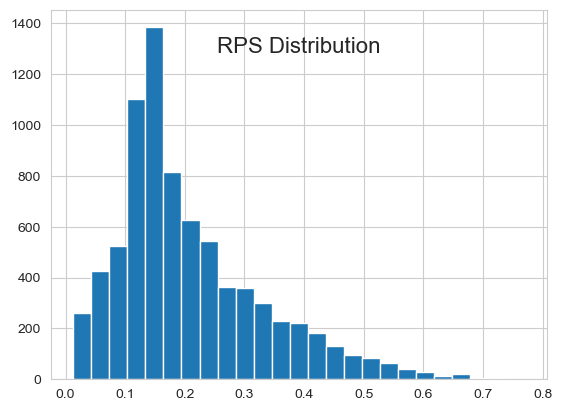

In [103]:
# Plot RPS distribution
plt.annotate("RPS Distribution", (0.5, 0.9), xycoords='axes fraction', ha='center', va='center', size=16)
plt.hist(all_rps, bins=25)
plt.savefig("../images/rps_distribution232.png", dpi=300)



"""
for team, team_ratings in ratings.items():
    print(f"Team: {team}")
    print(f"Background Rating Home: {team_ratings['brH']}")
    print(f"Background Rating Away: {team_ratings['brA']}")
    print(f"Continuous Over/Underperformances: {team_ratings['continuous_overunderperformances']}")
    print()
"""
;

In [ ]:
# Gridsearch on lambda and gamma

# Initialize the rates


# Define a parameter grid with the ranges for your parameters
param_grid = {
    'lambda': np.linspace(0.033, 0.041, int((0.041 - 0.033) / 0.001) + 1),
    'gamma': np.linspace(0.95, 1.0, int((1.0 - 0.95) / 0.01) + 1)

}

# Create a ParameterGrid object from the dictionary
grid = ParameterGrid(param_grid)

# Initialize the best_score variable
best_score = float('inf')  # assuming lower scores are better

# Create an empty list to store the results
gs_results = []

# Loop over the parameter combinations
for params in tqdm.tqdm(grid):
    # Update the rates dictionary
    rates.update(params)
    
    ratings, league_ratings = initialize_ratings(df_results, df_fixtures)
    
    # Re-train model with the new parameters
    ratings, games_with_ratings, training_games = update_ratings_multiple_games(df_results, ratings, league_ratings, rates)

    df_train = pd.DataFrame(training_games)
    #df_train.to_csv("../data/train232.csv", index=False)
    model = train_model(df_train)

    all_rps, league_tables = predict_outcomes(df_fixtures, ratings, league_ratings, rates, model)
    score = np.mean(all_rps)

    # Store the current results
    gs_results.append({
        'lambda': rates['lambda'],
        'gamma': rates['gamma'],
        'score': score,
    })

# Sort the results based on the score and get the top 5
top_5_combinations = sorted(gs_results, key=lambda x: x['score'])[:5]

print("Top 5 combinations:")
for combo in top_5_combinations:
    print(f"Lambda: {combo['lambda']}, Gamma: {combo['gamma']}, Score: {combo['score']}")

# Convert the gs_results to a DataFrame and plot them
df_gs_results = pd.DataFrame(gs_results)

# Define grid of x, y values
lambda_range = np.linspace(df_gs_results['lambda'].min(), df_gs_results['lambda'].max(), num=50)
gamma_range = np.linspace(df_gs_results['gamma'].min(), df_gs_results['gamma'].max(), num=50)
lambda_grid, gamma_grid = np.meshgrid(lambda_range, gamma_range)

# Interpolate z values for this grid
rps_grid = griddata((df_gs_results['lambda'], df_gs_results['gamma']), df_gs_results['score'], (lambda_grid, gamma_grid), method='cubic')


In [ ]:
# Create 3D surface plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(lambda_grid, gamma_grid, rps_grid, cmap='RdYlGn_r', edgecolor='none')
ax.set_xlabel('Lambda')
ax.set_ylabel('Gamma')
ax.set_zlabel('RPS Score', fontsize=10, labelpad=5)
ax.invert_zaxis()  # To make lower scores appear higher
#fig.colorbar(surf)
plt.savefig("../images/3d_plot_gs232.png", dpi=300)
plt.show()

# Create 2D plot with colormap
plt.figure(figsize=(10, 10))  # Adjust figsize to your preference to make the plot square
plt.title('Grid Search Scores')

cmap_reversed = plt.cm.get_cmap('RdYlGn_r')  # Reversed Red-Yellow-Green colormap

# Here we store the image object returned by imshow
im = plt.imshow(rps_grid, interpolation='nearest', cmap=cmap_reversed,
           extent=(param_grid['learning_rate_lambda'].min(), param_grid['learning_rate_lambda'].max(), param_grid['learning_rate_gamma'].min(), param_grid['learning_rate_gamma'].max()), origin='lower')

# We use the stored image object for the colorbar
plt.colorbar(im, cmap=cmap_reversed)

plt.axis('square')  # This will enforce a square aspect ratio

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("Lambda")
plt.ylabel("Gamma")
plt.savefig("../images/2d_plot_heat_gs232.png", dpi=300)
plt.show()

# Convert grid search results into a pivot table for plotting
pivot_table = df_gs_results.pivot('learning_rate_lambda', 'learning_rate_gamma', 'score')

# Create contour plot
plt.figure(figsize=(10,7))
contour_plot = plt.contourf(pivot_table.columns, pivot_table.index, pivot_table.values, cmap='RdYlGn_r', levels=100)
plt.title('Grid Search RPS Scores')
plt.xlabel('Lambda')
plt.ylabel('Gamma')

# Add a colorbar
cbar = plt.colorbar(contour_plot)
cbar.ax.set_ylabel('RPS Score')

plt.savefig("../images/2d_plot_contour_gs232.png", dpi=300)
plt.show()
;

In [ ]:

# Potential values for lambda2 and gamma2
potential_lambda2_values = np.linspace(0.1, 0.2, num=11)  
potential_gamma2_values = np.linspace(0.9, 1.0, num=11)  

# Lists to hold the parameter 'lambda2', 'gamma2' and the corresponding RPS values
parameter_values = []
rps_values = []

# Iterate over potential lambda2 and gamma2 values
for lambda2 in potential_lambda2_values:
    for gamma2 in potential_gamma2_values:
        _, league_ratings = initialize_ratings(df_results, df_fixtures, df_int_results, df_int_fixtures)
        
        # Update rates dictionary with the current lambda2 and gamma2 values
        rates['lambda2'] = lambda2
        rates['gamma2'] = gamma2

        # ... [Your existing code to update ratings and calculate RPS]
        league_ratings = update_league_ratings_multiple_games(df_int_results, league_ratings, rates)
        int_rps = predict_outcomes_int(df_int_fixtures, ratings, league_ratings, rates, model)
        # Calculate the mean RPS score for this combination
        mean_rps = np.mean(int_rps)
        
        # Store the lambda2, gamma2, and corresponding RPS value
        parameter_values.append((lambda2, gamma2))
        rps_values.append(mean_rps)

# Identify top 5 parameter combinations
top_indices = np.argsort(rps_values)[:5]  # gets the indices of the 5 lowest RPS scores
top_parameters = [parameter_values[i] for i in top_indices]
top_rps_values = [rps_values[i] for i in top_indices]

# Print top 5 parameter combinations
for i in range(5):
    print(f"Rank {i+1}, Parameters (lambda2, gamma2): {top_parameters[i]}, RPS Score: {top_rps_values[i]}")


In [ ]:
def optimize_int_threshold(df_results, df_fixtures, rates):
    # Define range for int_threshold
    thresholds = np.arange(5000, 45000, 5000)  

    # Initialize the best_score variable
    best_score = float('inf')  

    # Create an empty list to store the results
    optimization_results = []

    for threshold in tqdm.tqdm(thresholds):
        # Update rates with the current threshold
        rates['int_threshold'] = threshold

        ratings, league_ratings = initialize_ratings(df_results, df_fixtures)
        
        # Train and evaluate your model with the current threshold
        ratings, games_with_ratings, training_games = update_ratings_multiple_games(df_results, ratings, league_ratings, rates)
        
        df_train = pd.DataFrame(training_games)
        df_train.to_csv("../data/train232.csv", index=False)
        model = train_model(df_train)

        all_rps, league_tables = predict_outcomes(df_fixtures, ratings, league_ratings, rates, model)
        score = np.mean(all_rps)

        # If the current score is better than the best_score, update best_score
        if score < best_score:
            best_score = score
            best_threshold = threshold

        # Store the current score and threshold
        optimization_results.append({
            'int_threshold': threshold,
            'score': score,
        })

    # Convert the results to a DataFrame and sort by score
    df_optimization_results = pd.DataFrame(optimization_results).sort_values(by='score', ascending=True)

    # Display the top 5 combinations of the threshold and their score
    print(df_optimization_results.head())

    return best_threshold, best_score

# Call the function and get the best threshold and its score
best_threshold, best_score = optimize_int_threshold(df_results, df_fixtures, rates)
print(f"Best int_threshold: {best_threshold}")
print(f"Best score: {best_score}")


In [ ]:

# 1. Define the parameter grid
param_grid = {
    'mu': np.linspace(0.06, 0.08, 3),  # This gives 31 steps, starting from 0 to 0.03 inclusive
    'phi': np.linspace(1, 3, 3),  # This gives 41 steps, starting from 0 to 4 inclusive
    'delta': np.linspace(11, 13, 3)  # This gives 21 steps, starting from 1 to 3 inclusive
}

# Initialize the best_score variable and best_params dictionary
best_score = float('inf')
best_params = {}

# Create an empty list to store the results
gs_results = []

# 2. Iterate over the parameter combinations
for params in tqdm.tqdm(ParameterGrid(param_grid)):
    # Extract rates from params and merge with the existing rates dictionary
    current_rates = rates.copy()
    current_rates.update(params)
    
    
    # Train and predict with current_rates (and current_model if necessary)
    ratings, league_ratings = initialize_ratings(df_results, df_fixtures)

    # 3. Re-train model with the new parameters
    ratings, games_with_ratings, training_games = update_ratings_multiple_games(df_results, ratings, league_ratings, current_rates)

    df_train = pd.DataFrame(training_games)
    #df_train.to_csv("../data/train232.csv", index=False)
    current_model = train_model(df_train)
    # If your training method updates the model based on rates, you should train it here
    
    all_rps, league_tables = predict_outcomes(df_fixtures, ratings, league_ratings, current_rates, current_model)
    score = np.mean(all_rps)

    # 4. If the current score is better than the best_score, update best_score and best_params
    if score < best_score:
        best_score = score
        best_params = params

    # Store the current score and parameters
    gs_results.append({
        'mu': params['mu'],
        'phi': params['phi'],
        'delta': params['delta'],
        'score': score,
    })

# 5. Identify the best parameters based on the score
print(f'Best score: {best_score}')
print(f'Best params: {best_params}')

# Convert the gs_results to a DataFrame
df_gs_results = pd.DataFrame(gs_results)

# Sort the results by score and get the top 5
top_5_results = df_gs_results.sort_values(by='score', ascending=True).head(5)

print("Top 5 parameter combinations:")
print(top_5_results)


In [ ]:
# Lists to hold the parameter 'rho', 'sigma' and the corresponding RPS values
parameter_values = []
rps_values = []

# Grid of potential values for rho and sigma
potential_rho_values = np.linspace(0.75, 1.0, num=26)
potential_sigma_values = np.linspace(0.5, 0.7, num=21)

# Iterate over potential rho and sigma values
for rho in potential_rho_values:
    for sigma in potential_sigma_values:
        rates['rho'] = rho
        rates['sigma'] = sigma
        
        # Obtain the RPS for the current value of rho and sigma
        int_rps = predict_outcomes_int(df_int_fixtures, ratings, league_ratings, rates, model)

        # Compute the average RPS
        avg_rps = np.mean(int_rps)

        # Add current result to the lists
        parameter_values.append((rho, sigma))
        rps_values.append(avg_rps)

# Identify top 5 parameter combinations
top_indices = np.argsort(rps_values)[:5]  # gets the indices of the 5 lowest RPS scores
top_parameters = [parameter_values[i] for i in top_indices]
top_rps_values = [rps_values[i] for i in top_indices]

# Print top 5 parameter combinations
for i in range(5):
    print(f"Rank {i+1}, Parameters (rho, sigma): {top_parameters[i]}, RPS Score: {top_rps_values[i]}")


In [ ]:
# Generate meshgrid for 3D plot
a_grid, b_grid = np.meshgrid(potential_a_values, potential_b_values)

# Reshape rps_values into grid
rps_grid = np.array(rps_values).reshape(a_grid.shape)

# Create 3D surface plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(a_grid, b_grid, rps_grid, cmap='RdYlGn_r', edgecolor='none')
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('RPS Score', fontsize=10, labelpad=5)
ax.invert_zaxis()  # To make lower scores appear higher
plt.savefig("../images/3d_plot_ab_rps.png", dpi=300)
plt.show()


In [ ]:
import seaborn as sns

# Convert numpy arrays to lists
a_values = [round(a, 2) for a in potential_a_values]
b_values = [round(b, 2) for b in potential_b_values]

# Reshape RPS values to the shape of the grid
rps_grid = np.array(rps_values).reshape(len(a_values), len(b_values))

# Create a dataframe from the grid
df_rps = pd.DataFrame(rps_grid, index=a_values, columns=b_values)

# Create the heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(df_rps, cmap='RdYlGn_r', annot=False, fmt=".3f")
plt.title('Heatmap of RPS scores for different values of "a" and "b"')
plt.xlabel('b')
plt.ylabel('a')

# Invert y-axis
ax.invert_yaxis()

plt.savefig("../images/heatmap_ab_rps.png", dpi=300)
plt.show()



In [ ]:
import seaborn as sns
from matplotlib.patches import Rectangle


# Convert numpy arrays to lists
a_values = [round(a, 2) for a in potential_a_values]
b_values = [round(b, 2) for b in potential_b_values]

# Reshape RPS values to the shape of the grid
rps_grid = np.array(rps_values).reshape(len(a_values), len(b_values))

# Create a dataframe from the grid
df_rps = pd.DataFrame(rps_grid, index=a_values, columns=b_values)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(df_rps, cmap='RdYlGn_r', annot=False, fmt=".3f")
plt.title('Heatmap of RPS scores for different values of "a" and "b"')
plt.xlabel('b')
plt.ylabel('a')

# Manually highlight the best area
highlight_a = 0.25
highlight_b = 1.05

# Add a red rectangle around the cell to highlight it
for _, spine in ax.spines.items():
    spine.set_visible(True)
ax.add_patch(Rectangle((b_values.index(highlight_b), a_values.index(highlight_a)), 1, 1, fill=False, edgecolor='red', lw=3))

ax.invert_yaxis()
plt.savefig("../images/heatmap_ab_rps1.png", dpi=300)
plt.show()


In [ ]:
from matplotlib.patches import Rectangle


# Manually highlight the best area
highlight_a = 0.25
highlight_b = 1.05

# Find indices of the desired range in a_values and b_values
start_a_index = a_values.index(0)
end_a_index = a_values.index(0.5) + 1  # plus 1 to include 0.5
start_b_index = b_values.index(0.75)
end_b_index = b_values.index(1.25) + 1  # plus 1 to include 1.25

# Select subsets
a_values_subset = a_values[start_a_index:end_a_index]
b_values_subset = b_values[start_b_index:end_b_index]
rps_grid_subset = rps_grid[start_a_index:end_a_index, start_b_index:end_b_index]

# Create a heatmap
fig, ax = plt.subplots(figsize=(10, 7))
cax = ax.matshow(rps_grid_subset, origin='lower', cmap='RdYlGn_r')
fig.colorbar(cax)
# Move x-axis labels to bottom
ax.xaxis.tick_bottom()
ax.set_xticks(range(len(b_values_subset)))
ax.set_yticks(range(len(a_values_subset)))
ax.set_xticklabels(np.round(b_values_subset, 2))
ax.set_yticklabels(np.round(a_values_subset, 2))

plt.title('Heatmap of RPS scores for different values of "a" and "b"')
plt.xlabel('b')
plt.ylabel('a')

plt.savefig("../images/heatmap_ab_rps2.png", dpi=300)
plt.show()
